---
# Predicting House Prices in Tashkent
### Dataset: Tashkent housing dataset (scraped from uybor.uz)
### Model: Multiple Linear Regression
---

#### CRISP-DM:
<img src="resources/crisp-dm.jpg" alt="CRISP-DM" width="800"/>

---

**STEPS:**
1. Exploratory Data Analysis
    1. Data Understanding
    2. Data Cleaning
    3. Analyzing Data
4. Data Preparation
5. Pipeline for Feature Engineering
6. Machine Learning
7. Evaluation
8. Saving the Model

In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set()

In [2]:
df = pd.read_csv("https://github.com/anvarnarz/praktikum_datasets/blob/main/housing_data_08-02-2021.csv?raw=True")
df

,location,district,rooms,size,level,max_levels,price
0,"город Ташкент, Юнусабадский район, Юнусабад 8-...",Юнусабадский,3,57,4,4,52000
1,"город Ташкент, Яккасарайский район, 1-й тупик ...",Яккасарайский,2,52,4,5,56000
2,"город Ташкент, Чиланзарский район, Чиланзар 2-...",Чиланзарский,2,42,4,4,37000
3,"город Ташкент, Чиланзарский район, Чиланзар 9-...",Чиланзарский,3,65,1,4,49500
4,"город Ташкент, Чиланзарский район, площадь Актепа",Чиланзарский,3,70,3,5,55000
...,...,...,...,...,...,...,...
7560,"город Ташкент, Яшнободский район, Городок Авиа...",Яшнободский,1,38,5,5,24500
7561,"город Ташкент, Яшнободский район, 1-й проезд А...",Яшнободский,2,49,1,4,32000
7562,"город Ташкент, Шайхантахурский район, Зульфиях...",Шайхантахурский,2,64,3,9,40000
7563,"город Ташкент, Мирзо-Улугбекский район, Буюк И...",Мирзо-Улугбекский,1,18,1,4,11000


### Dataset Description:

- `location` - address of the house for sale
- `district` - district where the house is located
- `rooms` - number of rooms
- `size` - house area (sq.m)
- `level` - level(floor) where the house located
- `max_levels` - total number of levels
- `price` - price of the house

### Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   location    7565 non-null   object
 1   district    7565 non-null   object
 2   rooms       7565 non-null   int64 
 3   size        7565 non-null   object
 4   level       7565 non-null   int64 
 5   max_levels  7565 non-null   int64 
 6   price       7565 non-null   object
dtypes: int64(3), object(4)
memory usage: 413.8+ KB


We can see that there are no `NaN` values in the dataset. However, despite the fact that `size` and `price` columns are numbers, their data type is `object`. First, we convert these columns to numeric values.

#### Data Cleaning

In [4]:
size_col = np.array(df['size'], dtype='float64')
size_col

ValueError: could not convert string to float: 'Площадьземли:1сот'

In [5]:
df[df['size']=='Площадьземли:1сот']

,location,district,rooms,size,level,max_levels,price
5347,"город Ташкент, Яшнободский район, Дархон",Яшнободский,4,Площадьземли:1сот,3,5,150000


`size` column has non-numeric value: **'Площадьземли:1сот'**.\
It's like russian word *«сотка»* whichis is equal `100 m²`. [Wiki reference](https://ru.wikipedia.org/wiki/%D0%A1%D0%BE%D1%82%D0%BA%D0%B0#:~:text=%D0%90%D1%80%20(%D0%B2%20%D1%80%D0%B0%D0%B7%D0%B3%D0%BE%D0%B2%D0%BE%D1%80%D0%BD%D0%BE%D0%B9%20%D1%80%D0%B5%D1%87%D0%B8%20%D1%82%D0%B0%D0%BA%D0%B6%D0%B5%20%C2%AB%D1%81%D0%BE%D1%82%D0%BA%D0%B0%C2%BB%2C%20%D0%BE%D1%82%201/100%20%D0%B3%D0%B5%D0%BA%D1%82%D0%B0%D1%80%D0%B0)%C2%A0%E2%80%94%20%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F%20%D0%B5%D0%B4%D0%B8%D0%BD%D0%B8%D1%86%D0%B0%20%D0%B8%D0%B7%D0%BC%D0%B5%D1%80%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D0%B8%2C%20%D1%80%D0%B0%D0%B2%D0%BD%D0%B0%D1%8F%20100%C2%A0%D0%BC%C2%B2.)\
This means that we can convert this to a number.

In [6]:
df.loc[5347, 'size'] = 100
df.loc[[5347]]

,location,district,rooms,size,level,max_levels,price
5347,"город Ташкент, Яшнободский район, Дархон",Яшнободский,4,100,3,5,150000


In [7]:
size_col = np.array(df['size'], dtype='float64')
df['size'] = size_col

In [8]:
price_col = np.array(df['price'], dtype='float64')
price_col

ValueError: could not convert string to float: 'Договорная'

In [9]:
df[df['price']=='Договорная']

,location,district,rooms,size,level,max_levels,price
202,"город Ташкент, Яккасарайский район, Баходыра",Яккасарайский,3,119.0,3,9,Договорная
411,"город Ташкент, Яккасарайский район, Баходыра",Яккасарайский,4,160.0,4,9,Договорная
439,"город Ташкент, Мирзо-Улугбекский район, улица ...",Мирзо-Улугбекский,3,105.0,5,6,Договорная
460,"город Ташкент, Чиланзарский район, Чиланзар 1-...",Чиланзарский,3,90.0,6,8,Договорная
507,"город Ташкент, Яшнободский район, 1-й проезд А...",Яшнободский,2,48.0,4,4,Договорная
...,...,...,...,...,...,...,...
7039,"город Ташкент, Яшнободский район, Городок Авиа...",Яшнободский,1,38.7,3,8,Договорная
7196,"город Ташкент, Чиланзарский район, Чиланзар-16",Чиланзарский,2,51.0,3,4,Договорная
7323,"город Ташкент, Мирзо-Улугбекский район, жилой ...",Мирзо-Улугбекский,6,208.0,1,7,Договорная
7403,"город Ташкент, Учтепинский район, Чиланзар 14-...",Учтепинский,2,35.0,2,9,Договорная


`price` column also has non-numeric values: **'Договорная'**, which we can translate as *'negotiable'*. We need to convert this value to `NaN` value in order to filling it later.

In [10]:
indices = df[df['price'] == 'Договорная'].index
df.loc[indices, 'price'] = np.nan
df.loc[indices]

,location,district,rooms,size,level,max_levels,price
202,"город Ташкент, Яккасарайский район, Баходыра",Яккасарайский,3,119.0,3,9,NaN
411,"город Ташкент, Яккасарайский район, Баходыра",Яккасарайский,4,160.0,4,9,NaN
439,"город Ташкент, Мирзо-Улугбекский район, улица ...",Мирзо-Улугбекский,3,105.0,5,6,NaN
460,"город Ташкент, Чиланзарский район, Чиланзар 1-...",Чиланзарский,3,90.0,6,8,NaN
507,"город Ташкент, Яшнободский район, 1-й проезд А...",Яшнободский,2,48.0,4,4,NaN
...,...,...,...,...,...,...,...
7039,"город Ташкент, Яшнободский район, Городок Авиа...",Яшнободский,1,38.7,3,8,NaN
7196,"город Ташкент, Чиланзарский район, Чиланзар-16",Чиланзарский,2,51.0,3,4,NaN
7323,"город Ташкент, Мирзо-Улугбекский район, жилой ...",Мирзо-Улугбекский,6,208.0,1,7,NaN
7403,"город Ташкент, Учтепинский район, Чиланзар 14-...",Учтепинский,2,35.0,2,9,NaN


In [11]:
price_col = np.array(df['price'], dtype='float64')
df['price'] = price_col

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    7565 non-null   object 
 1   district    7565 non-null   object 
 2   rooms       7565 non-null   int64  
 3   size        7565 non-null   float64
 4   level       7565 non-null   int64  
 5   max_levels  7565 non-null   int64  
 6   price       7466 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 413.8+ KB


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rooms,7565.0,2.625644,1.085201,1.0,2.0,3.0,3.0,10.0
size,7565.0,113.267236,1491.213517,1.0,50.0,66.0,86.0,70000.0
level,7565.0,3.699273,2.237275,1.0,2.0,3.0,5.0,19.0
max_levels,7565.0,6.038202,2.613271,1.0,4.0,5.0,9.0,25.0
price,7466.0,71334.210421,640523.683731,2.0,35000.0,46500.0,67000.0,52000000.0


We can see *outliers* in `price` and `size` column.

#### Visualization

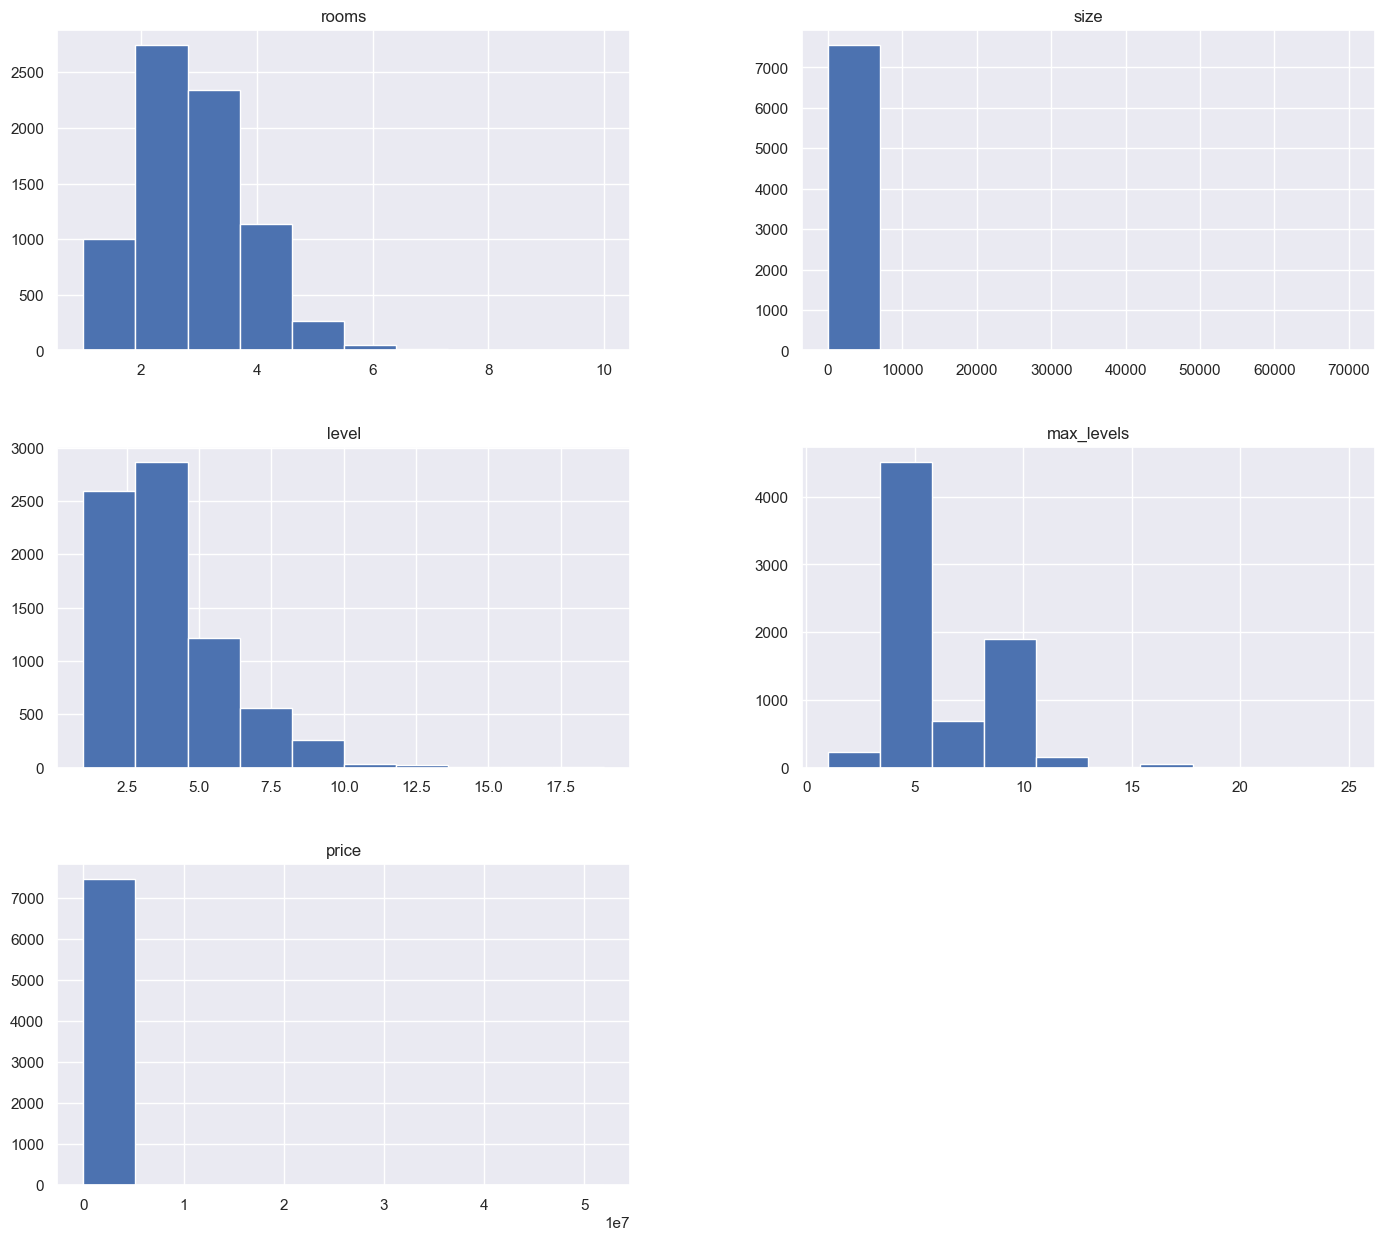

In [14]:
df.hist(figsize=[17, 15]);

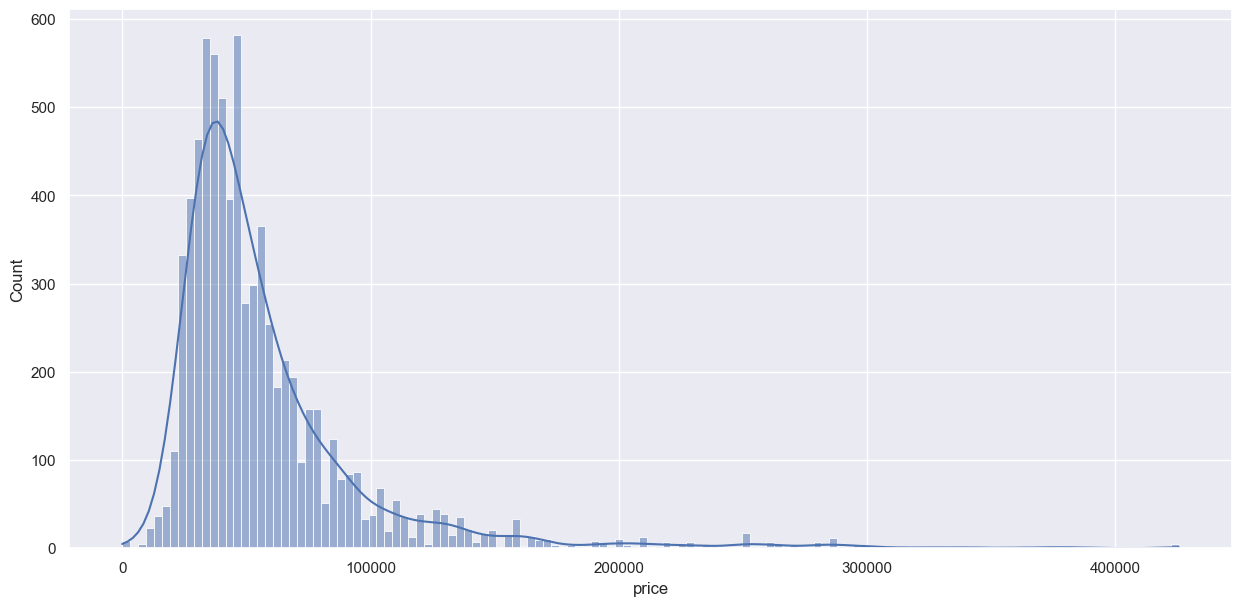

In [15]:
plt.figure(figsize=[15, 7])
sns.histplot(x=df[df['price'] < 500_000]['price'], kde=True);

There are many outliers in the `price` column, we need to correct them.

In [16]:
price_mask = (df['price'] >= 5000) & (df['price'] < 150_000)
df = df[price_mask]

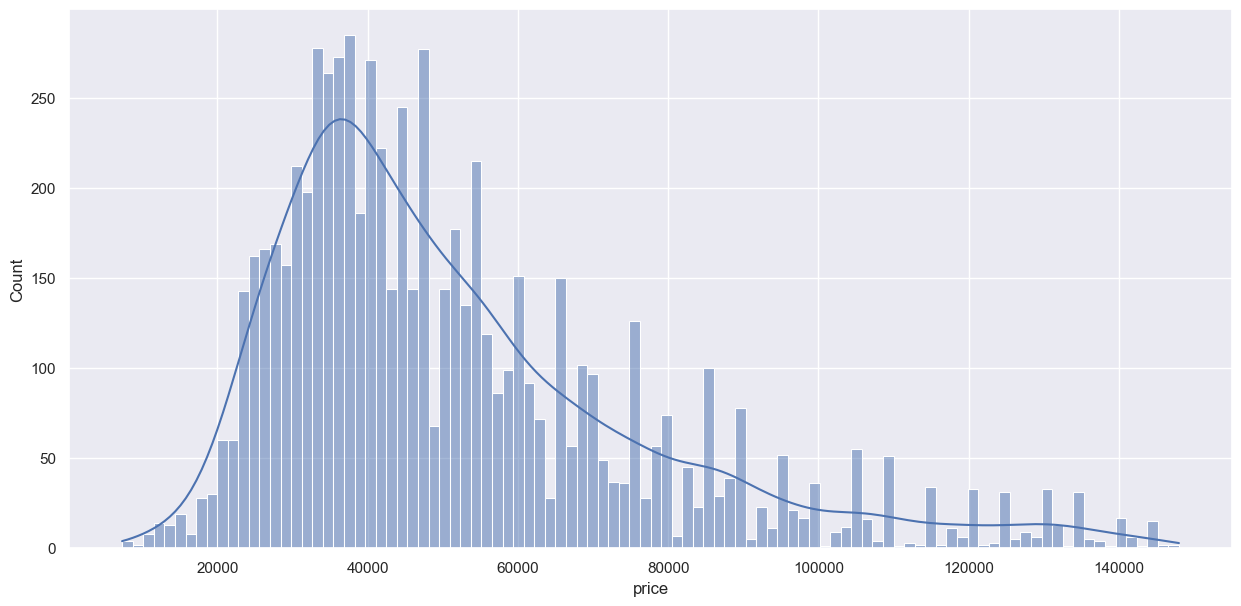

In [17]:
plt.figure(figsize=[15, 7])
sns.histplot(x=df['price'], kde=True, bins=100);

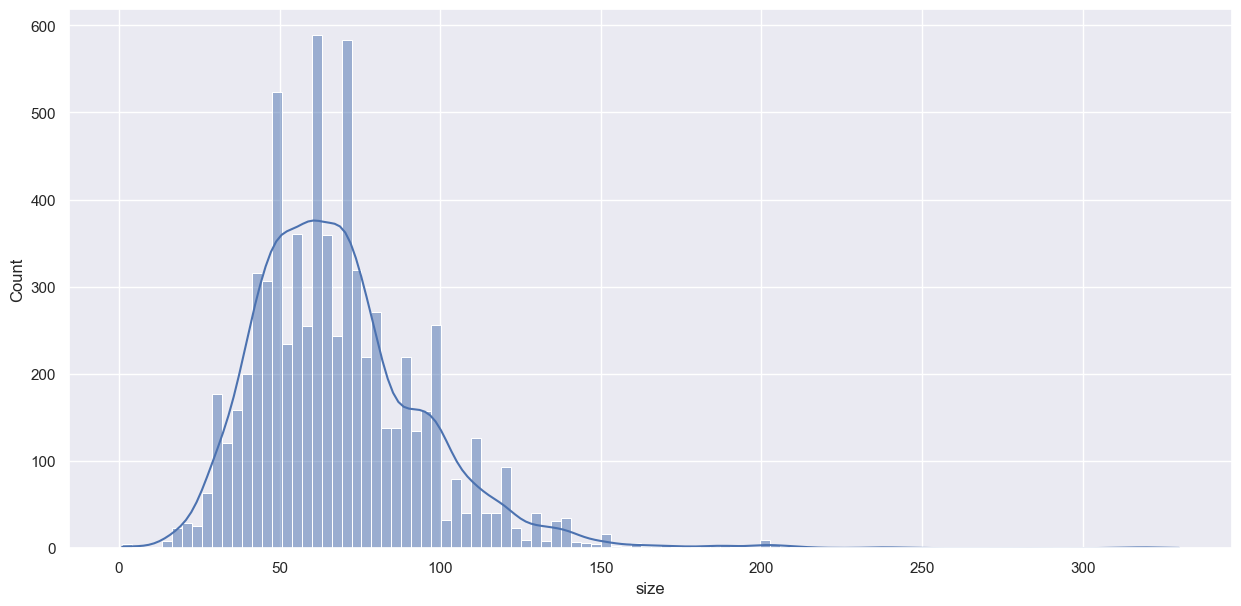

In [18]:
plt.figure(figsize=[15, 7])
sns.histplot(x=df[df['size'] < 3000]['size'], kde=True);

We remove outliers with values less than or equal to `10` and greater than or equal to `155` in the `size` column.

In [19]:
size_mask = (df['size'] >= 10) & (df['size'] <= 155)
df = df[size_mask]

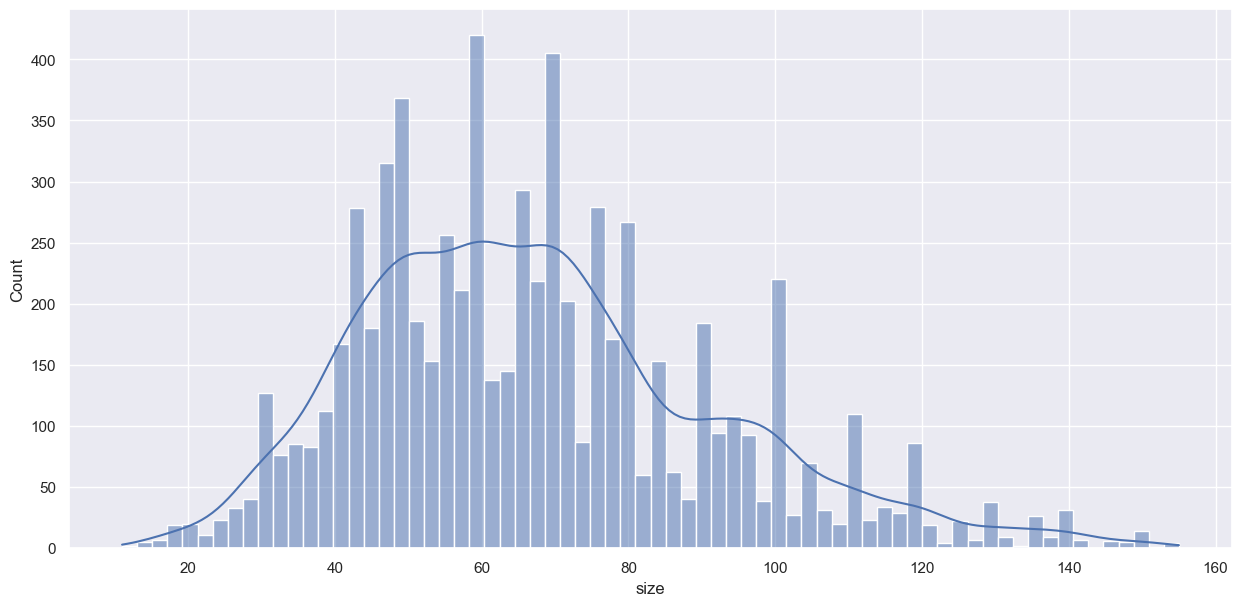

In [20]:
plt.figure(figsize=[15, 7])
sns.histplot(x=df['size'], kde=True, bins=70);

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rooms,7070.0,2.535078,0.993457,1.0,2.0,2.0,3.0,6.0
size,7070.0,67.621788,24.306545,11.0,50.0,65.0,80.0,155.0
level,7070.0,3.676803,2.222154,1.0,2.0,3.0,5.0,18.0
max_levels,7070.0,5.956153,2.586963,1.0,4.0,5.0,9.0,25.0
price,7070.0,51441.008911,24603.311716,7300.0,34500.0,45000.0,62000.0,148000.0


In [22]:
avg_price = df.groupby('district')['price'].mean().sort_values(ascending=False)
avg_price

district
Мирабадский          74785.387786
Шайхантахурский      60127.307018
Яккасарайский        58272.158598
Юнусабадский         53761.020531
Мирзо-Улугбекский    50530.390805
Олмазорский          48850.488189
Яшнободский          44832.683036
Учтепинский          44558.040230
Чиланзарский         43993.622642
Сергелийский         43417.426752
Янгихаётский         37000.000000
Бектемирский         29462.500000
Name: price, dtype: float64

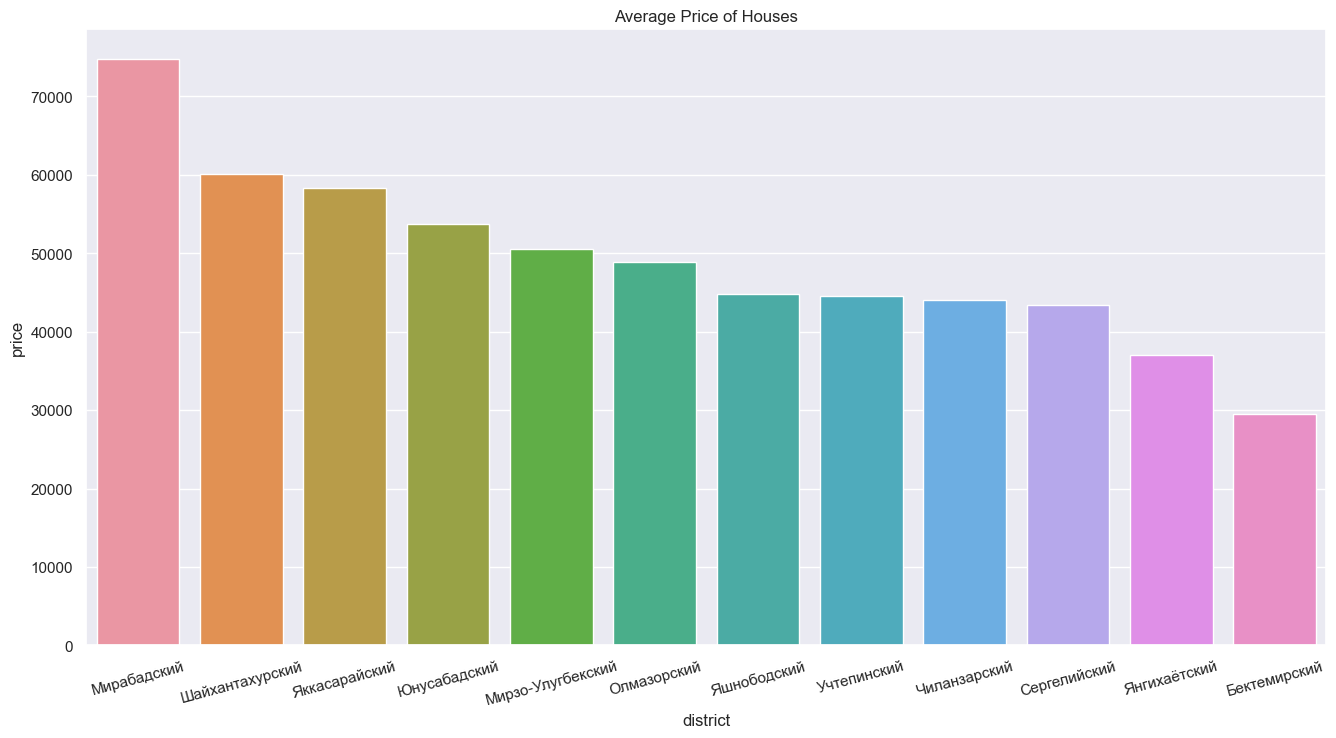

In [23]:
plt.figure(figsize=[16, 8])
sns.barplot(x=avg_price.index, y=avg_price)
plt.title("Average Price of Houses")
plt.xticks(rotation=15);

In [24]:
df.corr(numeric_only=True).style.background_gradient(cmap='Blues')

,rooms,size,level,max_levels,price
rooms,1.000000,0.846877,0.141529,0.165177,0.619922
size,0.846877,1.000000,0.209476,0.320719,0.774511
level,0.141529,0.209476,1.000000,0.597209,0.076230
max_levels,0.165177,0.320719,0.597209,1.000000,0.252789
price,0.619922,0.774511,0.076230,0.252789,1.000000


We can see there is good correlation between `price` and `size` columns.

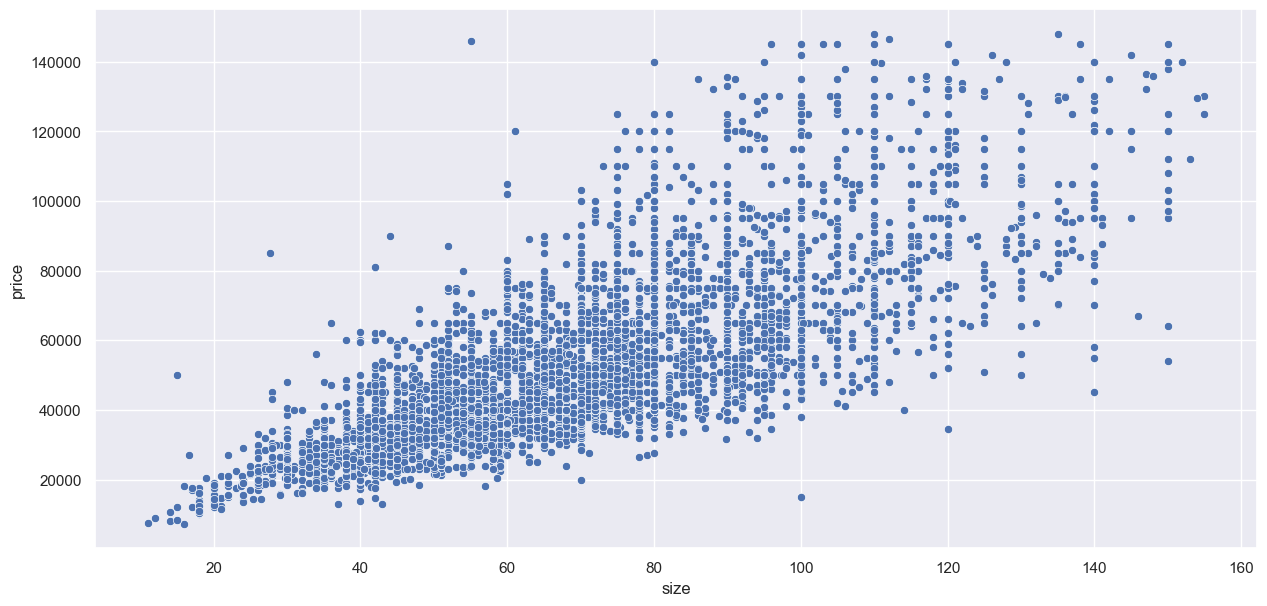

In [25]:
plt.figure(figsize=[15, 7])
sns.scatterplot(data=df, x='size', y='price');

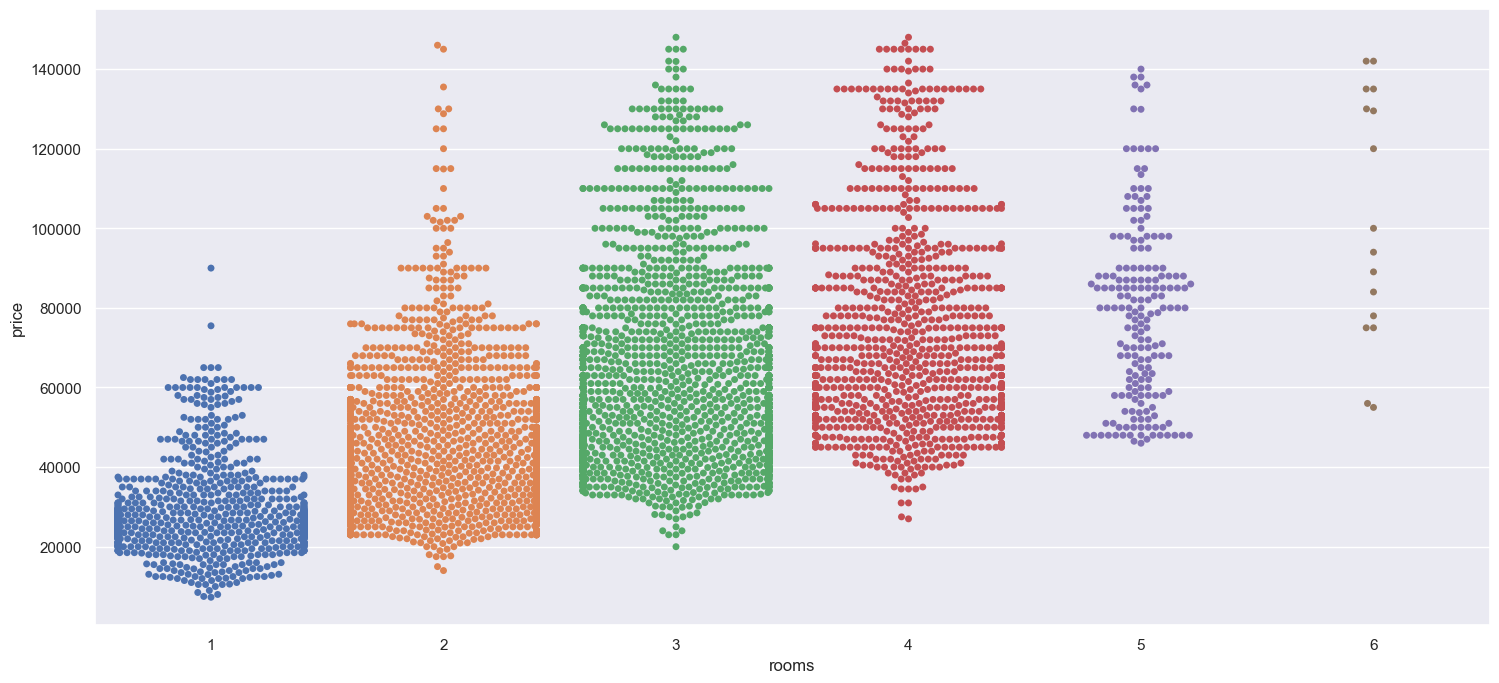

In [26]:
import warnings
warnings.simplefilter('ignore')

plt.figure(figsize=[18, 8])
sns.swarmplot(data=df, x='rooms', y='price', palette='deep');

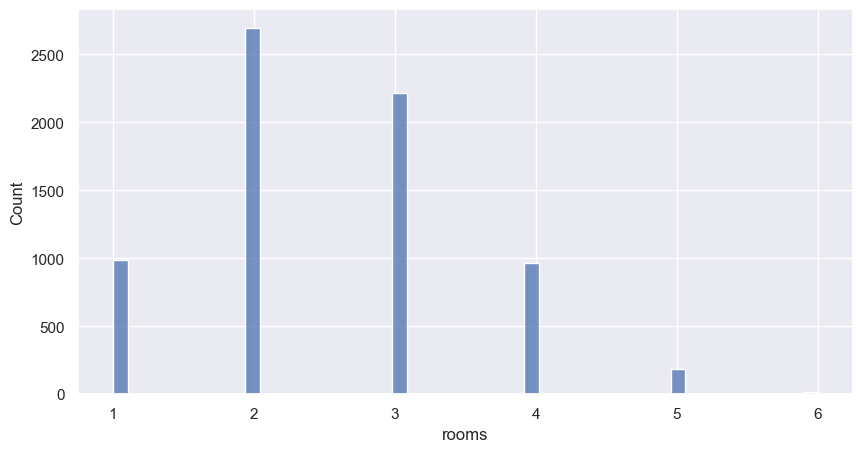

In [27]:
plt.figure(figsize=[10, 5])
sns.histplot(x=df.rooms);

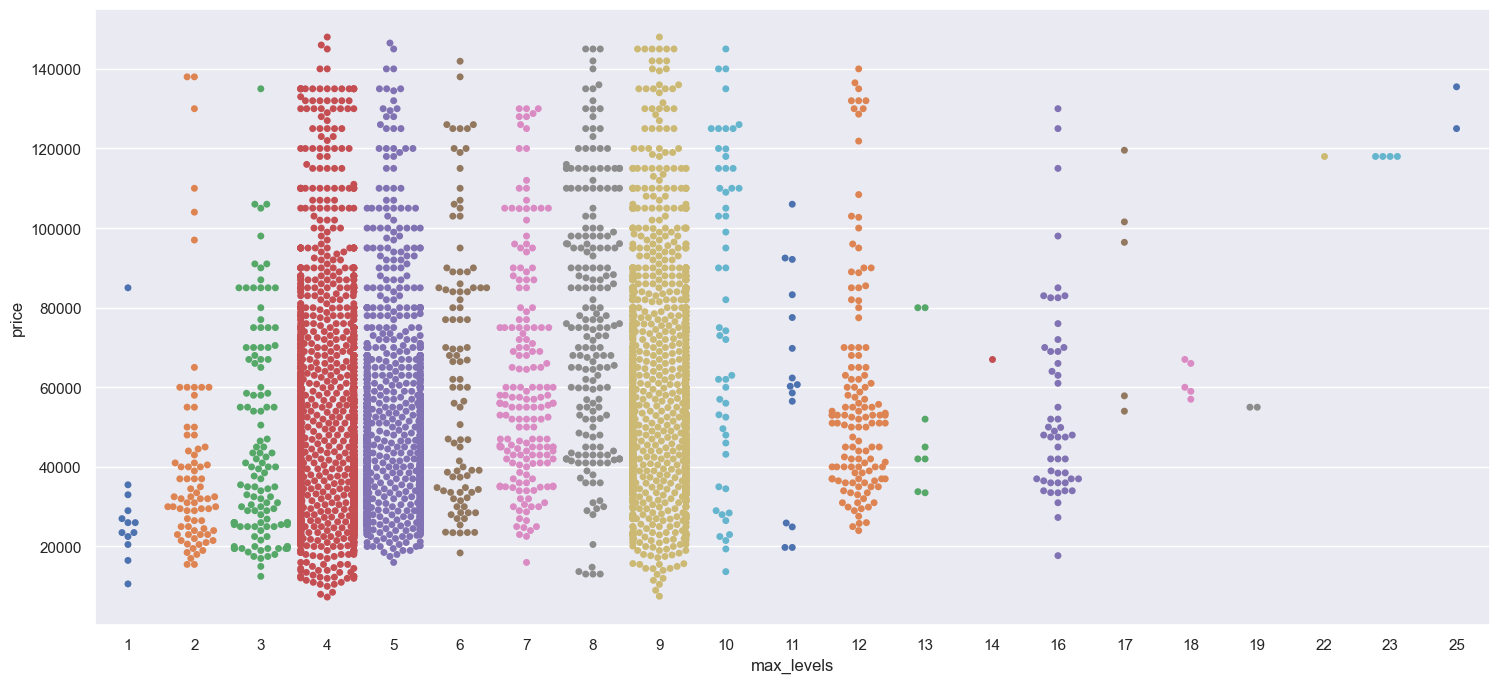

In [28]:
plt.figure(figsize=[18, 8])
sns.swarmplot(data=df, x='max_levels', y='price', palette='deep');

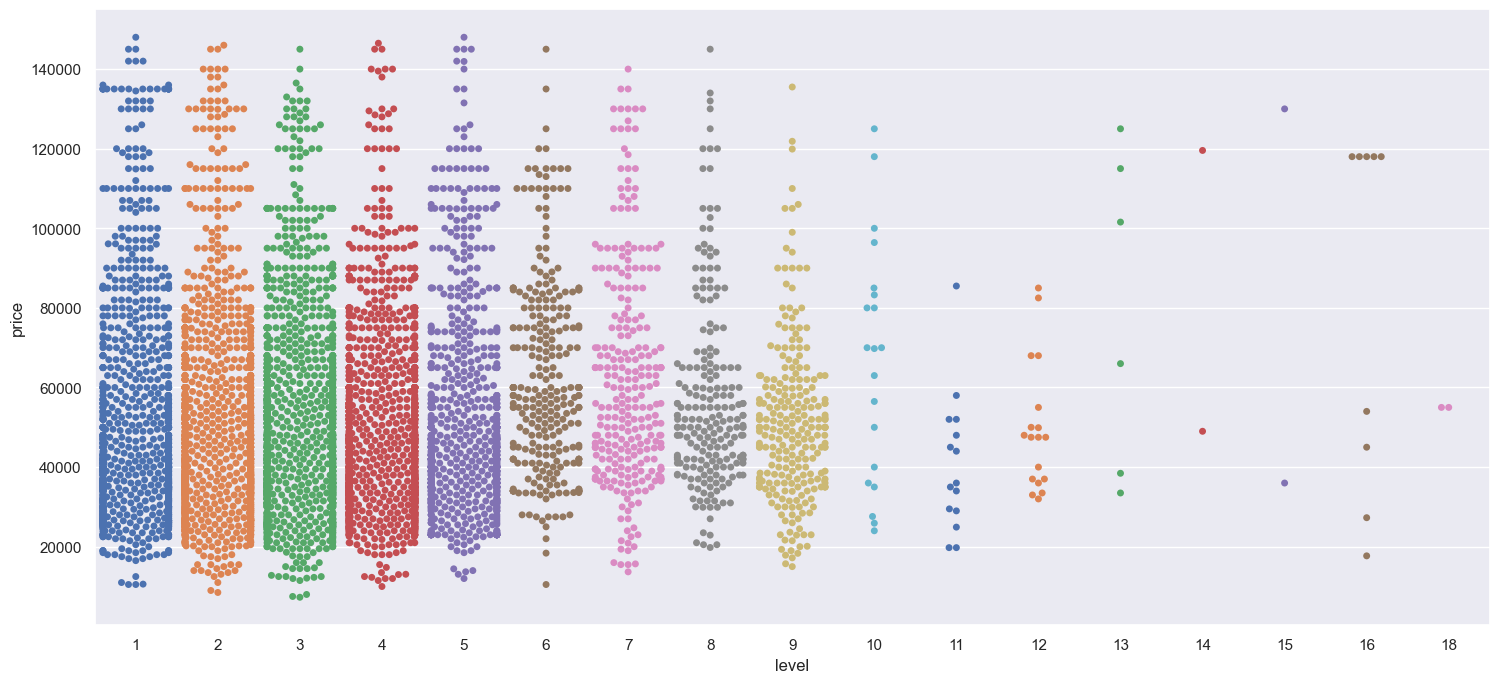

In [29]:
plt.figure(figsize=[18, 8])
sns.swarmplot(data=df, x='level', y='price', palette='deep');

In [30]:
df.corrwith(df['price'], numeric_only=True).sort_values(ascending=False)

price         1.000000
size          0.774511
rooms         0.619922
max_levels    0.252789
level         0.076230
dtype: float64

In [31]:
df.head()

,location,district,rooms,size,level,max_levels,price
0,"город Ташкент, Юнусабадский район, Юнусабад 8-...",Юнусабадский,3,57.0,4,4,52000.0
1,"город Ташкент, Яккасарайский район, 1-й тупик ...",Яккасарайский,2,52.0,4,5,56000.0
2,"город Ташкент, Чиланзарский район, Чиланзар 2-...",Чиланзарский,2,42.0,4,4,37000.0
3,"город Ташкент, Чиланзарский район, Чиланзар 9-...",Чиланзарский,3,65.0,1,4,49500.0
4,"город Ташкент, Чиланзарский район, площадь Актепа",Чиланзарский,3,70.0,3,5,55000.0


### Data Preparation | Feature Engineering

**Step by Step:**

**1.** Handling Missing Values \
**2.** Exploring and Creating New Features \
**3.** Encoding Categorical Values \
**4.** Feature Scaling

Since this is just an experiment and to avoid an unexpected modifications to the original df we will copy it to temporary df (We perform actual feature engineering with the pipeline):

---

In [32]:
data = df.copy()
data.head()

,location,district,rooms,size,level,max_levels,price
0,"город Ташкент, Юнусабадский район, Юнусабад 8-...",Юнусабадский,3,57.0,4,4,52000.0
1,"город Ташкент, Яккасарайский район, 1-й тупик ...",Яккасарайский,2,52.0,4,5,56000.0
2,"город Ташкент, Чиланзарский район, Чиланзар 2-...",Чиланзарский,2,42.0,4,4,37000.0
3,"город Ташкент, Чиланзарский район, Чиланзар 9-...",Чиланзарский,3,65.0,1,4,49500.0
4,"город Ташкент, Чиланзарский район, площадь Актепа",Чиланзарский,3,70.0,3,5,55000.0


#### Handling Missing Values

In [33]:
# # Handling missing values (if we had NaN values)

# imputer = SimpleImputer(strategy="mean")
# num_cols = data.drop(['location', 'district'], axis=1).columns
# num_values = imputer.fit_transform(data[num_cols])
# data_num = pd.DataFrame(num_values, columns=num_cols, index=data[num_cols].index)
# data_num

We do not have any missing values. It is beacuase in the process of handling outliers in visualization part, we also got rid of `NaN` values.

#### Exploring New Features

We can create additional features from the current dataset in order to improve model accuracy:
- `room_size_ratio`: The ratio of the number of rooms to the size of the house. It could be useful in identifying houses that have more rooms than their size would suggest, or vice versa.

- `level_size_ratio`: The ratio of the number of levels to the size of the house. It could be useful in identifying houses that have more levels than their size would suggest, or vice versa.

- `price_per_sqrt`: The price of the house divided by its size. It could be useful in identifying how much a house costs per square root, which can be a useful comparison metric.

- `price_per_room`: The price of the house divided by the number of rooms. It could be useful in identifying how much a house costs per room, which can be a useful comparison metric.

- `level_maxlevels_ratio`: The ratio of levels of the house to the maximum possible levels of the house. It could be useful in identifying houses that have higher or lower levels than their maximum possible levels.

- `district_density`: We could use district column and count the number of houses in each district, and divide it by the size of the district to get a measure of the district density.

- `location_density`: Similar to district density, we could use location column and count the number of houses in each location, and divide it by the size of the location to get a measure of the location density.

In [34]:
data['room_size_ratio'] = data['rooms'] / data['size']
data['level_size_ratio'] = data['level'] / data['size']
data['price_per_sqrt'] = data['price'] / data['size']
data['price_per_room'] = data['price'] / data['rooms']
data['level_maxlevels_ratio'] = data['level'] / data['max_levels']
# Create a new column for district density
district_counts = data['district'].value_counts()
data['district_density'] = data['district'].map(district_counts) / len(data)
# Create a new column for location density
location_counts = data['location'].value_counts()
data['location_density'] = data['location'].map(location_counts) / len(data)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7070 entries, 0 to 7564
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   location               7070 non-null   object 
 1   district               7070 non-null   object 
 2   rooms                  7070 non-null   int64  
 3   size                   7070 non-null   float64
 4   level                  7070 non-null   int64  
 5   max_levels             7070 non-null   int64  
 6   price                  7070 non-null   float64
 7   room_size_ratio        7070 non-null   float64
 8   level_size_ratio       7070 non-null   float64
 9   price_per_sqrt         7070 non-null   float64
 10  price_per_room         7070 non-null   float64
 11  level_maxlevels_ratio  7070 non-null   float64
 12  district_density       7070 non-null   float64
 13  location_density       7070 non-null   float64
dtypes: float64(9), int64(3), object(2)
memory usage: 828.5+ 

In [36]:
data.corrwith(data['price'], numeric_only=True).sort_values(ascending=False)

price                    1.000000
size                     0.774511
rooms                    0.619922
price_per_sqrt           0.602245
price_per_room           0.487870
max_levels               0.252789
level                    0.076230
location_density        -0.043260
room_size_ratio         -0.073234
level_maxlevels_ratio   -0.127211
district_density        -0.155471
level_size_ratio        -0.327301
dtype: float64

#### Encoding Categorical Values

In [37]:
data.head()

,location,district,rooms,size,level,max_levels,price,room_size_ratio,level_size_ratio,price_per_sqrt,price_per_room,level_maxlevels_ratio,district_density,location_density
0,"город Ташкент, Юнусабадский район, Юнусабад 8-...",Юнусабадский,3,57.0,4,4,52000.0,0.052632,0.070175,912.280702,17333.333333,1.00,0.117115,0.002263
1,"город Ташкент, Яккасарайский район, 1-й тупик ...",Яккасарайский,2,52.0,4,5,56000.0,0.038462,0.076923,1076.923077,28000.000000,0.80,0.084724,0.000141
2,"город Ташкент, Чиланзарский район, Чиланзар 2-...",Чиланзарский,2,42.0,4,4,37000.0,0.047619,0.095238,880.952381,18500.000000,1.00,0.224894,0.011033
3,"город Ташкент, Чиланзарский район, Чиланзар 9-...",Чиланзарский,3,65.0,1,4,49500.0,0.046154,0.015385,761.538462,16500.000000,0.25,0.224894,0.004950
4,"город Ташкент, Чиланзарский район, площадь Актепа",Чиланзарский,3,70.0,3,5,55000.0,0.042857,0.042857,785.714286,18333.333333,0.60,0.224894,0.000707


In [38]:
data['location'].value_counts()

город Ташкент, Чиланзарский район, Чиланзар                112
город Ташкент, Яккасарайский район, Кушбеги                108
город Ташкент, Мирзо-Улугбекский район, Буюк Ипак Йули      83
город Ташкент, Яккасарайский район, Бабура                  79
город Ташкент, Учтепинский район, Чиланзар 24-й квартал     79
                                                          ... 
город Ташкент, Мирзо-Улугбекский район, Укитувчи             1
город Ташкент, Юнусабадский район, 8-й проезд Янгишахар      1
город Ташкент, Учтепинский район, 1-й проезд Козигузар       1
город Ташкент, Олмазорский район, Каракамыш2/4               1
город Ташкент, Яшнободский район, Базар Кадышева             1
Name: location, Length: 1493, dtype: int64

This feature confusing, we remove it.

In [39]:
data.drop('location', axis=1, inplace=True)
data.head()

,district,rooms,size,level,max_levels,price,room_size_ratio,level_size_ratio,price_per_sqrt,price_per_room,level_maxlevels_ratio,district_density,location_density
0,Юнусабадский,3,57.0,4,4,52000.0,0.052632,0.070175,912.280702,17333.333333,1.00,0.117115,0.002263
1,Яккасарайский,2,52.0,4,5,56000.0,0.038462,0.076923,1076.923077,28000.000000,0.80,0.084724,0.000141
2,Чиланзарский,2,42.0,4,4,37000.0,0.047619,0.095238,880.952381,18500.000000,1.00,0.224894,0.011033
3,Чиланзарский,3,65.0,1,4,49500.0,0.046154,0.015385,761.538462,16500.000000,0.25,0.224894,0.004950
4,Чиланзарский,3,70.0,3,5,55000.0,0.042857,0.042857,785.714286,18333.333333,0.60,0.224894,0.000707


We only have the `district` categorical column that has to be encoded.

In [40]:
data[['district']].value_counts()

district         
Чиланзарский         1590
Мирзо-Улугбекский    1305
Учтепинский           870
Юнусабадский          828
Мирабадский           655
Яккасарайский         599
Яшнободский           448
Шайхантахурский       342
Олмазорский           254
Сергелийский          157
Янгихаётский           14
Бектемирский            8
dtype: int64

In [41]:
cat_encoder = OneHotEncoder()
data_cat1hot = cat_encoder.fit_transform(df[['district']])
data_cat1hot.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Feature Scaling
We need to bring all values to a common range.

In [42]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
rooms,7070.0,2.535078,0.993457,1.000000,2.000000,2.000000,3.000000,6.000000
size,7070.0,67.621788,24.306545,11.000000,50.000000,65.000000,80.000000,155.000000
level,7070.0,3.676803,2.222154,1.000000,2.000000,3.000000,5.000000,18.000000
max_levels,7070.0,5.956153,2.586963,1.000000,4.000000,5.000000,9.000000,25.000000
price,7070.0,51441.008911,24603.311716,7300.000000,34500.000000,45000.000000,62000.000000,148000.000000
room_size_ratio,7070.0,0.037649,0.008338,0.013793,0.032787,0.038462,0.042857,0.200000
level_size_ratio,7070.0,0.059121,0.038163,0.006667,0.030928,0.051948,0.078431,0.466667
price_per_sqrt,7070.0,759.964693,212.804198,150.000000,619.047619,712.500000,862.386941,3333.333333
price_per_room,7070.0,21260.889510,8241.038367,6666.666667,15750.000000,19000.000000,25000.000000,90000.000000
level_maxlevels_ratio,7070.0,0.634832,0.282305,0.083333,0.400000,0.666667,0.888889,1.000000


In [43]:
data.head()

,district,rooms,size,level,max_levels,price,room_size_ratio,level_size_ratio,price_per_sqrt,price_per_room,level_maxlevels_ratio,district_density,location_density
0,Юнусабадский,3,57.0,4,4,52000.0,0.052632,0.070175,912.280702,17333.333333,1.00,0.117115,0.002263
1,Яккасарайский,2,52.0,4,5,56000.0,0.038462,0.076923,1076.923077,28000.000000,0.80,0.084724,0.000141
2,Чиланзарский,2,42.0,4,4,37000.0,0.047619,0.095238,880.952381,18500.000000,1.00,0.224894,0.011033
3,Чиланзарский,3,65.0,1,4,49500.0,0.046154,0.015385,761.538462,16500.000000,0.25,0.224894,0.004950
4,Чиланзарский,3,70.0,3,5,55000.0,0.042857,0.042857,785.714286,18333.333333,0.60,0.224894,0.000707


In [44]:
standart_scaler = StandardScaler()
standart_scaler.fit_transform(data.iloc[:, 1:])

array([[ 0.46801723, -0.43702382,  0.14545323, ...,  1.29361548,
        -0.31779577, -0.43953401],
       [-0.53863984, -0.64274428,  0.14545323, ...,  0.58511205,
        -0.82492874, -0.99030182],
       [-0.53863984, -1.05418521,  0.14545323, ...,  1.29361548,
         1.36969473,  1.83697296],
       ...,
       [-0.53863984, -0.14901517, -0.30459243, ..., -1.0680626 ,
        -1.39406923, -0.88014826],
       [-1.54529691, -2.04164343, -1.20468376, ..., -1.36327236,
         0.73854671,  2.02056223],
       [-1.54529691, -1.54791432, -0.7546381 , ..., -0.47764308,
         1.36969473,  0.14795166]])

### Pipeline for Feature Engineering

We can combine all the processes so far into a single pipeline, with this, we can automate Feature Engineering:
  - Handling missing(`NaN`) values (`SimpleImputer`)
  - Encoding categorical values (`OneHotEncoder`)
  - Transformer for adding extra features
  - Scaling numeric values (`StandardScaler`)

And combine all and return 1 prepared dataset.

#### Transformer
Transformer for adding extra features for `X_train` set.

In [45]:
df.shape

(7070, 7)

In [46]:
# Split train and test set
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (5656, 6)
y_train: (5656,)
X_test: (1414, 6)
y_test: (1414,)


In [47]:
X_train.head()

,location,district,rooms,size,level,max_levels
5495,"город Ташкент, Учтепинский район, Чиланзар 26-...",Учтепинский,2,52.0,5,5
552,"город Ташкент, Юнусабадский район, Юнусабад 18...",Юнусабадский,2,48.0,3,4
5876,"город Ташкент, Мирабадский район, Фергана Йули",Мирабадский,1,28.0,2,4
6077,"город Ташкент, Шайхантахурский район, Самаркан...",Шайхантахурский,2,75.0,4,7
743,"город Ташкент, Яшнободский район, Карасу 5",Яшнободский,3,67.0,4,4


In [48]:
# Indices of columns we need in X_train
rooms_ix, size_ix, level_ix, max_levels_ix = 0, 1, 2, 3

class ExtraFeaturesAdder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self  # our function is transformer not estimator
    
    def transform(self, X):
        if type(X) != np.ndarray:
            X = X.values
        
        price_per_sqrt = price / X[:, size_ix]
        price_per_room = price / X[:, rooms_ix]
        level_size_ratio = X[:, level_ix] / X[:, size_ix]
        level_maxlevels_ratio = X[:, level_ix] / X[:, max_levels_ix]
        room_size_ratio = X[:, rooms_ix] / X[:, size_ix]
        # creating a new column for district density
        district_density = pd.Series(district).map(district.value_counts()) / len(X)

        return np.c_[X, price_per_sqrt, price_per_room, level_size_ratio,
                       district_density, level_maxlevels_ratio, room_size_ratio]

In [49]:
num_cols = make_column_selector(dtype_include='number')
cat_col = ['district']

preprocessor_pipeline = make_column_transformer(
    (make_pipeline(ExtraFeaturesAdder(), StandardScaler()), num_cols),
    (OneHotEncoder(), cat_col)
)

In [50]:
district = X_train['district'].copy()
price = y_train.copy()

X_train_set = preprocessor_pipeline.fit_transform(X_train)
X_train_set

array([[-0.54588418, -0.65033721,  0.59226343, ...,  0.        ,
         0.        ,  0.        ],
       [-0.54588418, -0.81498273, -0.303536  , ...,  0.        ,
         0.        ,  0.        ],
       [-1.55356072, -1.63821032, -0.75143572, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.55356072, -1.35008066, -0.75143572, ...,  0.        ,
         0.        ,  0.        ],
       [-1.55356072, -1.22659652, -0.75143572, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.46179236,  1.73702281,  0.14436372, ...,  0.        ,
         0.        ,  0.        ]])

The dataset is ready for Machine Learning!

---

### Modeling / Machine Learning

In [51]:
# take a look at the shape of the train set
print(X_train_set.shape)
print(y_train.shape)

(5656, 22)
(5656,)


#### Linear Regression

In [52]:
LR_model = LinearRegression()
# training a linear regression model
LR_model.fit(X_train_set, y_train)

LinearRegression()

Testing the model

In [53]:
# select 5 random rows from X_train
test_data = X_train.sample(5)
test_data

,location,district,rooms,size,level,max_levels
7400,"город Ташкент, Мирабадский район, Туркистан",Мирабадский,3,88.0,4,9
3507,"город Ташкент, Юнусабадский район, Юнусабад 8-...",Юнусабадский,2,55.0,3,4
3270,"город Ташкент, Мирзо-Улугбекский район, Феруза-1",Мирзо-Улугбекский,3,60.0,3,4
3802,"город Ташкент, Чиланзарский район, Торговый це...",Чиланзарский,2,43.0,1,4
811,"город Ташкент, Чиланзарский район, Чиланзар-16",Чиланзарский,2,50.0,3,4


In [54]:
# we extract the prices corresponding to test_data
test_label = y_train.loc[test_data.index]
test_label

7400    45000.0
3507    34000.0
3270    37700.0
3802    33500.0
811     35500.0
Name: price, dtype: float64

In [55]:
# Preprocessing for test_data
district = test_data['district'].copy()
price = test_label.copy()

test_data_set = preprocessor_pipeline.transform(test_data)
test_data_set

array([[ 0.46179236,  0.83147246,  0.14436372,  1.15720435, -1.15548948,
        -0.75214657, -0.35336955,  0.97827932, -0.66948485, -0.42225153,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.54588418, -0.52685307, -0.303536  , -0.75456917, -0.66060167,
        -0.51298715, -0.11904492,  0.97827932,  0.41338383, -0.15501442,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.46179236, -0.32104617, -0.303536  , -0.75456917, -0.61356978,
        -1.04312386, -0.23620724,  0.97827932,  0.41338383,  1.44840824,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.54588418

In [56]:
# Prediction
pred_test_data = LR_model.predict(test_data_set)
pred_test_data

array([51250.18324167, 31379.22233441, 34935.95763894, 31639.59068068,
       33384.62793199])

In [57]:
pd.DataFrame({'Prediction': pred_test_data, 'Real': test_label})

,Prediction,Real
7400,51250.183242,45000.0
3507,31379.222334,34000.0
3270,34935.957639,37700.0
3802,31639.590681,33500.0
811,33384.627932,35500.0


### Evaluation

In [58]:
# Predictors for test set
X_test

,location,district,rooms,size,level,max_levels
132,"город Ташкент, Чиланзарский район, Чиланзар 6-...",Чиланзарский,2,37.0,1,4
244,"город Ташкент, Чиланзарский район, Чиланзар 9-...",Чиланзарский,4,76.0,4,4
533,"город Ташкент, Чиланзарский район, Чиланзар-9",Чиланзарский,3,64.0,2,5
2330,"город Ташкент, Мирабадский район, Шевченко",Мирабадский,2,50.0,4,4
825,"город Ташкент, Чиланзарский район, Домбрабад",Чиланзарский,2,48.0,1,4
...,...,...,...,...,...,...
2168,"город Ташкент, Мирзо-Улугбекский район, 1-й Па...",Мирзо-Улугбекский,1,41.0,3,4
6313,"город Ташкент, Чиланзарский район, Кошчинар",Чиланзарский,2,65.0,4,9
3111,"город Ташкент, Яккасарайский район, Бабура",Яккасарайский,2,60.0,2,5
4205,"город Ташкент, Олмазорский район, Каракамыш-1/2",Олмазорский,2,58.0,4,5


In [59]:
# Labels for test set
y_test

132     41000.0
244     43000.0
533     35200.0
2330    47000.0
825     36500.0
         ...   
2168    31000.0
6313    57200.0
3111    47000.0
4205    36000.0
2348    35000.0
Name: price, Length: 1414, dtype: float64

In [60]:
# Preprocessing for X_test
district = X_test['district'].copy()
price = y_test.copy()

X_test_set = preprocessor_pipeline.transform(X_test)
X_test_set

array([[-0.54588418, -1.2677579 , -1.19933543, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.4694689 ,  0.3375359 ,  0.14436372, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.46179236, -0.15640065, -0.75143572, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.54588418, -0.32104617, -0.75143572, ...,  1.        ,
         0.        ,  0.        ],
       [-0.54588418, -0.40336893,  0.14436372, ...,  0.        ,
         0.        ,  0.        ],
       [-0.54588418, -0.69149859, -0.303536  , ...,  0.        ,
         0.        ,  0.        ]])

In [61]:
# Prediction
y_predict = LR_model.predict(X_test_set)

We use Root Mean Square Error (RMSE) to compare prediction and real data:

In [62]:
lin_mse = mean_squared_error(y_test, y_predict)

print(f"RMSE: {np.sqrt(lin_mse)}")
print(f"MAE: {mean_absolute_error(y_test, y_predict)}")

RMSE: 4859.106646679283
MAE: 3095.740666743309


We will try other models to see if there is a better result.

#### Decision Tree

In [63]:
Tree_model = DecisionTreeRegressor()
Tree_model.fit(X_train_set, y_train)

DecisionTreeRegressor()

In [64]:
# prediction
y_pred = Tree_model.predict(X_test_set)

# evaluation
lin_mse = mean_squared_error(y_test, y_pred)

print(f"RMSE: {np.sqrt(lin_mse)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

RMSE: 1655.7309307778153
MAE: 483.4809052333805


*Better than before!*

#### Random Forest

In [65]:
RF_model = RandomForestRegressor()
RF_model.fit(X_train_set, y_train)

RandomForestRegressor()

In [66]:
# prediction
y_pred = RF_model.predict(X_test_set)

# evaluation
lin_mse = mean_squared_error(y_test, y_pred)

print(f"RMSE: {np.sqrt(lin_mse)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

RMSE: 834.2816788606847
MAE: 315.8869448373409


*Much better!*

### Cross-Validation

In [67]:
X.head()

,location,district,rooms,size,level,max_levels
0,"город Ташкент, Юнусабадский район, Юнусабад 8-...",Юнусабадский,3,57.0,4,4
1,"город Ташкент, Яккасарайский район, 1-й тупик ...",Яккасарайский,2,52.0,4,5
2,"город Ташкент, Чиланзарский район, Чиланзар 2-...",Чиланзарский,2,42.0,4,4
3,"город Ташкент, Чиланзарский район, Чиланзар 9-...",Чиланзарский,3,65.0,1,4
4,"город Ташкент, Чиланзарский район, площадь Актепа",Чиланзарский,3,70.0,3,5


In [68]:
y.head()

0    52000.0
1    56000.0
2    37000.0
3    49500.0
4    55000.0
Name: price, dtype: float64

In [69]:
print(X.shape)
print(y.shape)

(7070, 6)
(7070,)


In [70]:
# Preprocessing for X dataset
district = X['district'].copy()
price = y.copy()

X_set = preprocessor_pipeline.transform(X)
X_set

array([[ 0.46179236, -0.44453031,  0.14436372, ...,  0.        ,
         0.        ,  0.        ],
       [-0.54588418, -0.65033721,  0.14436372, ...,  1.        ,
         0.        ,  0.        ],
       [-0.54588418, -1.061951  ,  0.14436372, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.54588418, -0.15640065, -0.303536  , ...,  0.        ,
         0.        ,  0.        ],
       [-1.55356072, -2.04982412, -1.19933543, ...,  0.        ,
         0.        ,  0.        ],
       [-1.55356072, -1.55588756, -0.75143572, ...,  0.        ,
         0.        ,  0.        ]])

In [71]:
# Simple function for printing validation results
def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean: {scores.mean()}")
    print(f"STD: {scores.std()}")

#### LinearRegression

In [72]:
# validating with MSE
mse_scores = cross_val_score(LR_model, X_set, y, scoring="neg_mean_squared_error", cv=10)
LR_rmse_scores = np.sqrt(-mse_scores)
# validating with MAE
LR_mae_scores = cross_val_score(LR_model, X_set, y, scoring="neg_mean_absolute_error", cv=10)

print("---------- RMSE scores: ----------")
display_scores(LR_rmse_scores)
print("\n---------- MAE scores: ----------")
display_scores(-LR_mae_scores)

---------- RMSE scores: ----------
Scores: [4390.22890731 4499.83745424 5751.91554219 5188.88143686 5588.41266489
 5596.16648739 4771.4346195  5169.71243256 4831.88933153 6462.44127565]
Mean: 5225.092015213549
STD: 605.4796820488324

---------- MAE scores: ----------
Scores: [2831.13154173 2832.70155587 3668.47241867 3340.51768034 3538.25742574
 3139.49669088 2970.86562942 3249.05839689 3157.59759268 2980.35943165]
Mean: 3170.8458363868967
STD: 269.204759529892


#### DecisionTree

In [73]:
# validating with MSE
mse_scores = cross_val_score(Tree_model, X_set, y, scoring="neg_mean_squared_error", cv=10)
Tree_rmse_scores = np.sqrt(-mse_scores)
# validating with MAE
Tree_mae_scores = cross_val_score(Tree_model, X_set, y, scoring="neg_mean_absolute_error", cv=10)

print("---------- RMSE scores: ----------")
display_scores(Tree_rmse_scores)
print("\n---------- MAE scores: ----------")
display_scores(-Tree_mae_scores)

---------- RMSE scores: ----------
Scores: [ 934.87057247 1553.83952887 1686.64365123 2631.68700767 1560.33244427
 1907.4096852  1895.83200583 1435.46782265 1495.39391243 1795.08873755]
Mean: 1689.656536817307
STD: 411.78803944420264

---------- MAE scores: ----------
Scores: [388.03253182 451.46676096 557.21216407 663.11315417 462.10325318
 476.20933522 581.57567185 499.87553041 548.77934936 453.99009901]
Mean: 508.2357850070722
STD: 75.66117977593117


#### RandomForest

In [74]:
# validating with MSE
mse_scores = cross_val_score(RF_model, X_set, y, scoring="neg_mean_squared_error", cv=10)
RF_rmse_scores = np.sqrt(-mse_scores)
# validating with MAE
RF_mea_scores = cross_val_score(RF_model, X_set, y, scoring="neg_mean_absolute_error", cv=10)

print("---------- RMSE scores: ----------")
display_scores(RF_rmse_scores)
print("\n---------- MAE scores: ----------")
display_scores(-RF_mea_scores)

---------- RMSE scores: ----------
Scores: [ 572.6277334   879.03252084  989.99361664 2508.07404164  780.84484879
 1779.93597939 1064.73379409  919.97877743  795.44498322 1046.08716416]
Mean: 1133.6753459610022
STD: 548.0753963526925

---------- MAE scores: ----------
Scores: [254.00734088 326.28946252 401.68084866 502.51588402 312.70991513
 330.24551627 356.11768034 290.5890099  337.76018388 292.70724187]
Mean: 340.4623083451203
STD: 66.01459279197475


**Conclusion:**

The best performing model -> *RF_model (RandomForestRegressor)*. `RMSE: ~1150` and `MAE: ~344`

---

### Saving the Model

`!pip install joblib`

In [75]:
import joblib

joblib.dump(RF_model, "tashkent_house_price_rf_pred.jbl")

['tashkent_house_price_rf_pred.jbl']

**Using the model:**

In [76]:
model = joblib.load("tashkent_house_price_rf_pred.jbl")

In [77]:
model.score(X_test_set, y_test)

0.9987792376629422

In [78]:
print("Done!")

Done!
